<a href="https://colab.research.google.com/github/tald747/Deep-learning-model---project-5/blob/main/signatures_verification_siameseNet_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signatures verification using SiameseNet

In [ ]:
# Import all the necessary Library 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn 
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import PIL.ImageOps    
from PIL import Image
import urllib #<! Download internet files
import shutil #<! Handle zip files
import itertools
import random
import datetime
import time
import os

!pip install torchinfo #<! display model summary
from torchinfo import summary

# Set fixed random number seed
torch.manual_seed(42)

In [2]:
# check if GPU device is active
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
  print('Deivece is: GPU')
else:
  print('Deivece is: CPU')

Deivece is: GPU


In [3]:
# connect to google drive to save dataset and models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load tensorboard and import summery writer 
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

## The Data


### Data import

In [5]:
# Login Into Kaggle
# See https://www.kaggle.com/general/74235
# See https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27
# The JSON file content:
# {"username":"fixelalgorithms","key":"53fb9c2e60051daa41be41cd5c9c8456"}

# read kaggel credentails from text file
f = open('/content/drive/MyDrive/siameseNetwork/Kaggel.txt', 'r')
lines = f.readlines()
username = lines[0].strip()
token = lines[1].strip()
f.close()

name = os.environ['KAGGLE_USERNAME'] = username
test = os.environ['KAGGLE_KEY'] = token

# !kaggle datasets download -d iarunava/happy-house-dataset #<! Download Kaggle Data Set
userName    = 'robinreni'
dataSetName = 'signature-verification-dataset'
!kaggle datasets download -d $userName/$dataSetName #<! Download Kaggle Data Set ($ for string interpolation)
shutil.unpack_archive(f'{dataSetName}.zip', './DataSet') #<! Unzip

 99% 593M/601M [00:18<00:00, 44.5MB/s]
100% 601M/601M [00:18<00:00, 34.6MB/s]


### Dataset Preprocessing and Generation

In [6]:
# create new train csv file containing only classes between 001-048, as original train file holds all the 69 signatures classes 
df_train = pd.read_csv('/content/DataSet/sign_data/train_data.csv', names=["image1","image2","label"], encoding = "UTF-8")
df_train_new = df_train[df_train['image1'].str[:3].astype(int)<49].sort_values('image1') # extract first 3 charecters, convert to int and filter the dataset
df_train_new.to_csv('/content/DataSet/sign_data/train_data_new.csv', header=False, index=False, encoding = "UTF-8")

# create sample data for testing model
train_sample = df_train_new.iloc[:10000,]
train_sample.to_csv('/content/DataSet/sign_data/train_sample.csv', header=False, index=False, encoding = "UTF-8")

In [ ]:
# check contenet of dataset library
from subprocess import check_output
print(check_output(["ls", "../content/DataSet/sign_data"]).decode("utf8"))

* Define paths for training and testing datasets and csv files

In [8]:
training_dir="../content/DataSet/sign_data/train"
training_csv="../content/DataSet/sign_data/train_sample.csv"
testing_csv="../content/DataSet/sign_data/test_data.csv"
testing_dir="../content/DataSet/sign_data/test"
real_dir='/content/drive/MyDrive/siameseNetwork/signatures'
real_csv='/content/drive/MyDrive/siameseNetwork/signatures/real_data.csv'

* Create Dataset class to generate a pair of images with label

In [9]:
class SiameseNetworkDataset():
    
    def __init__(self, training_csv=None, training_dir=None, transform=None, device=device):
        # used to prepare the labels and images path
        self.training_df= pd.read_csv(training_csv, names=["image1","image2","label"])
        self.training_dir = training_dir    
        self.transform = transform
        self.device = device

    def __getitem__(self,index):   
        # getting the image path
        image1_path=os.path.join(self.training_dir, self.training_df.iat[index, 0])
        image2_path=os.path.join(self.training_dir, self.training_df.iat[index, 1])
        
        # Loading images
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L") # Convert to one chanel (gray scale)
        img1 = img1.convert("L")
        
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        label = torch.from_numpy(np.array([int(self.training_df.iat[index, 2])], dtype=np.float32))
        label = label[0]
        return img0, img1, label
    
    def __len__(self):
        return len(self.training_df)

### Load and Batch the Data

In [10]:
class Config():
    train_batch_size = 32

In [11]:
# choose a training dataset size and further divide it into train and validation set

# Load the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(training_csv, training_dir, transform=None)

# Load a second dataset to be used for splitting data to train and val sets with different image transformers
train_dataset = SiameseNetworkDataset(training_csv, training_dir)

# generate indices: instead of the actual data we pass in integers instead
train_indices, val_indices, _, _ = train_test_split(
                                                    range(len(train_dataset)),
                                                    train_dataset.training_df.label,
                                                    test_size=0.1,
                                                    random_state=42,
                                                    shuffle=False
                                                    )
# generate subset based on indices
train_set = Subset(train_dataset, train_indices)
val_set = Subset(siamese_dataset, val_indices)

# define different image transformers for train and val sets
train_set.dataset.transform  = transforms.Compose([
                                                  transforms.RandomRotation((-3,3), fill=0, expand=True),
                                                  transforms.Resize((128,128)),
                                                  transforms.ToTensor()
                                                  ])
val_set.dataset.transform  = transforms.Compose([
                                                transforms.Resize((128,128)),
                                                transforms.ToTensor()
                                                ])
test_dataset = SiameseNetworkDataset(training_csv=testing_csv, training_dir=testing_dir,
                                    transform=transforms.Compose([transforms.Resize((128,128)),
                                                                  transforms.ToTensor()
                                                                  ])
                                    )
# load training data in batches
train_dataloader = DataLoader(train_set,
                              shuffle=True,
                              num_workers=2,
                              batch_size= Config.train_batch_size)
# load validation data in batches
val_dataloader = DataLoader(val_set,
                            shuffle=True,
                            num_workers=2,
                            batch_size= Config.train_batch_size)
# load test data in batches
test_dataloader = DataLoader(test_dataset,
                             num_workers=2,
                             batch_size=1,
                             shuffle=True)

* Small dataset of real personal signatures samples for testing model performance.

In [12]:
# dataset of real signatures samples for testing model result
real_dataset = SiameseNetworkDataset(training_csv=real_csv, training_dir=real_dir,
                                    transform=transforms.Compose([transforms.Resize((128,128)),
                                                                  transforms.ToTensor()
                                                                ])
                                    )
# load real dataset for testing
real_dataloader = DataLoader(real_dataset,
                              shuffle=True,
                              num_workers=2,
                              batch_size=1)

In [13]:
# A helper function to plot images
def imshow(img, text=None, should_save=False, aspect='auto'):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text ,fontsize=12, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

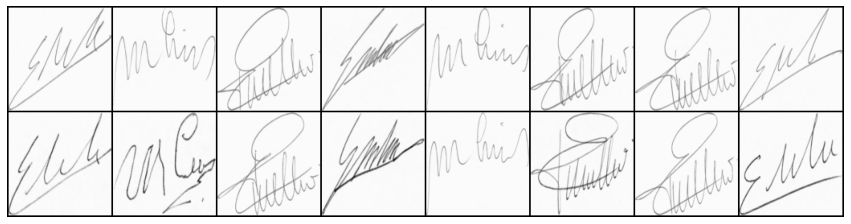

[1. 1. 0. 1. 0. 1. 0. 1.]


In [14]:
# View sample of images and check whether its loading properly
vis_dataloader = DataLoader(val_set, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)

plt.figure(figsize=[15, 15])
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Deep learning Model

### SiameseNet
Net architecture (Based on CNN)

In [15]:
#create a siamese network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(p=.2),

            nn.Conv2d(4, 8, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(p=.4),

            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*14*14, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=.3),
            nn.Linear(128, 16)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


#### Checkpoints:
A checkpoints mechanisim enabeling to save and load model with best parameters

In [16]:
# saving and loading checkpoint mechanisms

def save_checkpoint(save_path, model, optimizer, val_loss, epoch):
    if save_path==None:
      return
    save_path = save_path 
    state_dict = {'epoch': epoch+1,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}
    torch.save(state_dict, save_path)   
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer):
    save_path = f'/content/drive/MyDrive/siameseNetwork/siameseNet.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    epoch = state_dict['epoch']
    print(f'Model loaded from <== {save_path}')
        
    return model, optimizer, epoch, val_loss

#### Loss functions:
Two loss fucntion were tested in this model: ContrastiveLoss and BCEWithLotgitsLoss. At the end I used the BCEWithLotgitsLoss function since it gave better results.


In [17]:
class ContrastiveLoss(torch.nn.Module):
  def __init__(self, margin=2.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    #label should be one dimensional!!!
    euclidean_distance = F.pairwise_distance(output1, output2)
    loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    return loss

class MyBCELoss(nn.Module):
  def __init__(self):
    super(MyBCELoss, self).__init__()
    self.loss_fn = nn.BCEWithLogitsLoss()

  def forward(self, output1, output2, label):
    output = torch.max(abs(output1 - output2),1)[0]
    # output = (output1 * output2).sum(axis=1)
    return self.loss_fn(output, label)


In [18]:
def train(model, train_dataloader, val_dataloader, num_epochs, criterion, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    val_accuracy = []
    y_predicted = []
    y_target = []
 
    for epoch in range(num_epochs):
      running_loss = 0.0
      model.train()
      print("Starting epoch " + str(epoch+1))
      for i, data in enumerate(train_dataloader,0):
          img0, img1, label = data
          img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
          optimizer.zero_grad()
          output1, output2 = net(img0, img1)
          output = torch.max(abs(output1 - output2),1)[0] #>! disable when using ContrastiveLoss function
          loss = criterion(output, label)
          # loss = criterion(output1 ,output2, label) #>! enable when using ContrastiveLoss function and disable above line
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      avg_train_loss = running_loss / len(train_dataloader)
      train_losses.append(avg_train_loss)

      #check validation loss after every epoch      
      val_running_acc = 0.0
      val_running_loss = 0.0
      with torch.no_grad():
        model.eval()
        for img0, img1, label in val_dataloader:
            img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
            output1, output2 = net(img0, img1)
            output = torch.max(abs(output1 - output2),1)[0] #>! disable when using ContrastiveLoss function
            loss = criterion(output, label)
            # loss = criterion(output1 ,output2, label) #>! enable when using ContrastiveLoss function and disable above line
            val_running_loss += loss.item()
            result = torch.abs(output1 - output2)
            result = torch.max(result, 1)[0]
            y_pred = (result > 0.1)
            val_running_acc += torch.sum(y_pred == label.data)
        
      avg_val_loss = val_running_loss/len(val_dataloader)
      val_losses.append(avg_val_loss)
      avg_val_acc = val_running_acc/len(val_set)
      val_accuracy.append(avg_val_acc)
      print('Epoch [{}/{}]... Train Loss:{:.4f}... Valid Loss:{:.4f}... Val Accuracy:{:.4f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss, avg_val_acc))
      
      # save model with best evaluation loss
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_checkpoint(save_name, model, optimizer, best_val_loss, epoch+1)

      # write various tracked parameters to Tensorboard
      writer.add_graph(net, input_to_model=[img0, img1])
      writer.add_scalar('epoch training loss', avg_train_loss, epoch+1)
      writer.add_scalar('epoch Val loss', avg_val_loss, epoch+1)
      writer.add_scalar('epoch Val Accuracy', avg_val_acc, epoch+1)
      writer.close()

    print("Finished Training")  
    return train_losses, val_losses, val_accuracy  

### Train the model
* You have the option to load a saved model and retrain it. In this case, markout the 'net = Net().to(device)' at the top.

In [ ]:
# actual training
net = Net().to(device)
num_epochs = 50
lr = 0.00004
optimizer = optim.Adam(net.parameters(), lr=lr)
# criterion = ContrastiveLoss()
criterion = nn.BCEWithLogitsLoss()
save_path = '/content/drive/MyDrive/siameseNetwork/siameseNet.pt'

# Loading saved model for retrain
# net, optimizer, epoch, val_loss = load_checkpoint(net, optimizer)

# define Tensorboard writer configuration
comment = f'batch_size = {Config.train_batch_size} lr = {lr}'
log_folder = '/content/drive/MyDrive/siameseNetwork/runs/' +'siam_70 -' + datetime.datetime.now().strftime("%d%m%Y-%H%M%S") +  comment
writer = SummaryWriter(log_dir=log_folder, flush_secs=1)

train_losses, val_losses, val_accuracy = train(net, train_dataloader, val_dataloader, num_epochs, criterion, save_path)

### Tensorboard

In [ ]:
#!kill $(ps aux | awk '{print $2}') # kill tensorboard session <#! code used to forcefully terminate tensorboard session in colab when it fails to load

In [ ]:
tensorboard  --logdir='/content/drive/MyDrive/siameseNetwork/runs/'

### Model summary

In [ ]:
# Net layout and parameters
net = Net()
summary(net)

In [25]:
# view best saved model parameters
load_model = Net().to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.005)
best_model = load_checkpoint(load_model, load_optimizer)
best_model

Model loaded from <== /content/drive/MyDrive/siameseNetwork/siameseNet.pt


(Net(
   (cnn1): Sequential(
     (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU(inplace=True)
     (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (4): Dropout2d(p=0.2, inplace=False)
     (5): Conv2d(4, 8, kernel_size=(4, 4), stride=(1, 1))
     (6): ReLU(inplace=True)
     (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (9): Dropout2d(p=0.4, inplace=False)
     (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
     (11): ReLU(inplace=True)
     (12): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (14): Dropout2d(p=0.2, inplace=False)
   )
   (fc1): Sequential(
     (0): Linear(in_features=1

In [ ]:
# plotting of training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.figure(figsize=(15,15)).show();

## Model evaluation

### Test Trained Network Accuracy 

In [21]:
# Disable grad
with torch.no_grad():
  # Loading the saved model
  save_path = f'/content/drive/MyDrive/siameseNetwork/siameseNet.pt'
  net = Net().to(device)
  checkpoint = torch.load(save_path)
  net.load_state_dict(checkpoint['model_state_dict']) 
  net.eval()

accuracy=0
correct=0
for i, data in enumerate(test_dataloader, 0): 
  x0, x1, label = data
  # onehsot applies in the output of 128 dense vectors which is then converted to 16 dense vectors
  output1, output2 = net(x0.to(device), x1.to(device))
  result = torch.abs(output1.to(device) - output2.to(device))
  result = torch.max(result, 1)[0]
  result = torch.sigmoid(result).data.cpu().numpy()
  label = label.data.cpu().numpy()
  y_pred = 1 if result > 0.5 else 0
  correct += 1 if y_pred == label else 0

accuracy = (correct/len(test_dataloader))*100
print("Accuracy: {}/{} ({:.3}%)".format(correct, len(test_dataloader), accuracy)) 

Accuracy: 5321/5748 (92.6%)


### Visualize Signatures Similarity

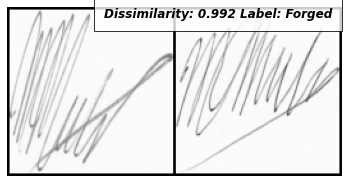

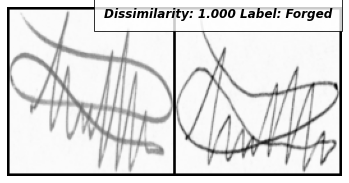

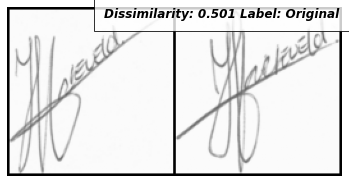

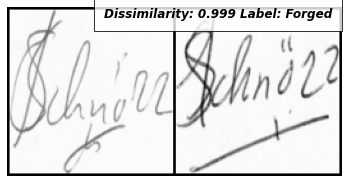

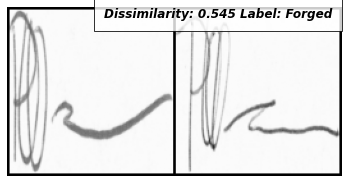

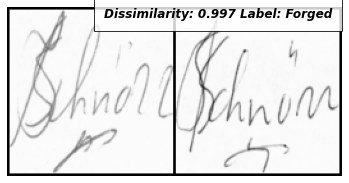

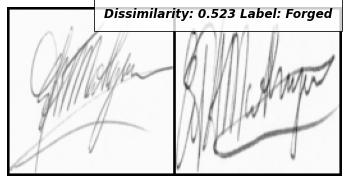

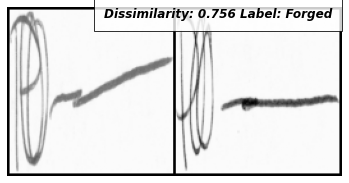

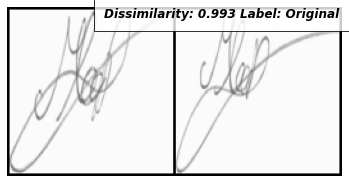

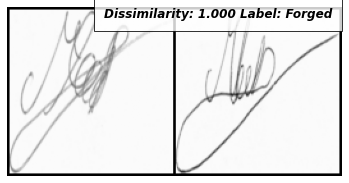

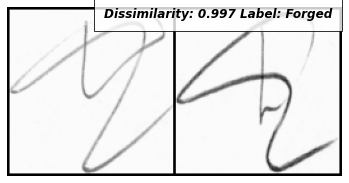

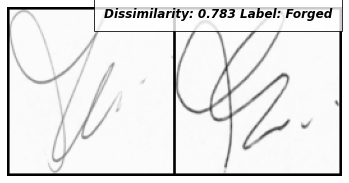

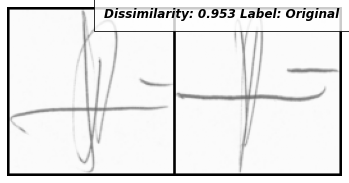

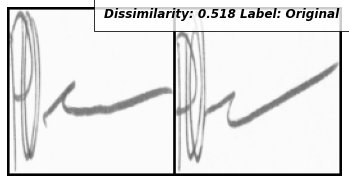

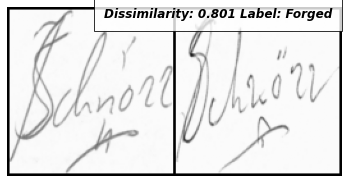

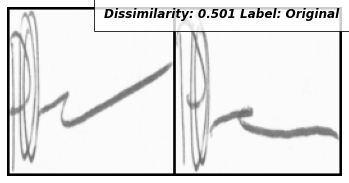

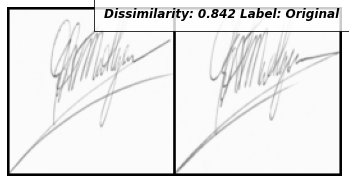

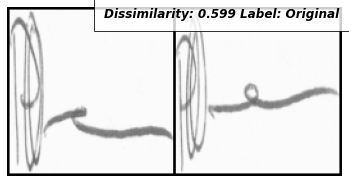

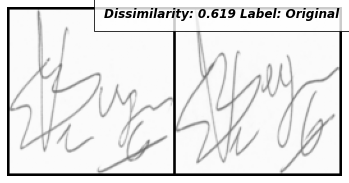

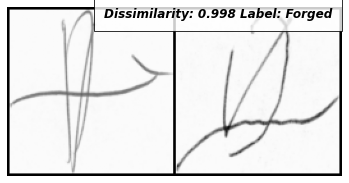

In [23]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([0])
list_1 = torch.FloatTensor([1])

# Loading the saved model
save_path = f'/content/drive/MyDrive/siameseNetwork/siameseNet.pt'
net = Net().to(device)
checkpoint = torch.load(save_path)
net.load_state_dict(checkpoint['model_state_dict']) 

for i, data in enumerate(test_dataloader, 0): 
  x0, x1, label = data
  concatenated = torch.cat((x0,x1),0)
  output1, output2 = net(x0.to(device), x1.to(device))
  result = torch.abs(output1.to(device) - output2.to(device))
  result = torch.max(result, 1)[0]
  result = torch.sigmoid(result).data.cpu().numpy()[0]
  label = label.data.cpu().numpy()[0]
  if label==list_0:
    label="Original"
  else:
    label="Forged"
    
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.3f} Label: {}'.format(result, label))
  counter=counter+1
  if counter ==20:
     break

### Test - Confusion matrix

Confusion matrix:
 [[2462  310]
 [ 117 2859]]


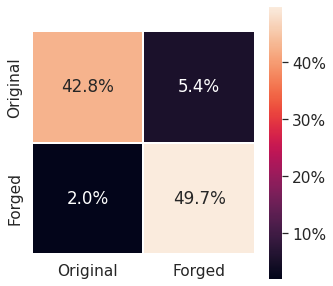

In [24]:
# Disable grad
with torch.no_grad():
  # Loading the saved model
  save_path = f'/content/drive/MyDrive/siameseNetwork/siameseNet.pt'
  net = Net().to(device)
  checkpoint = torch.load(save_path)
  net.load_state_dict(checkpoint['model_state_dict']) 
  net.eval()

  y_pred = []
  y_true = []

  # iterate over test data
  for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    output1, output2 = net(x0.to(device), x1.to(device))
    result = torch.abs(output1.to(device) - output2.to(device))
    result = torch.max(result, 1)[0]
    result = torch.sigmoid(result).data.cpu().numpy()
    label = label.data.cpu().numpy()
    result = [1 if result > 0.5 else 0]
    y_pred.extend(result) # predictions
    y_true.extend(label) # ground true

  # constant for classes
  classes = ('Original', 'Forged')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize=(5,5))
  sn.set(font_scale=1.4)
  ax = sn.heatmap(df_cm, annot=True, fmt='.1%',square=1, linewidth=1.)
  cbar = ax.collections[0].colorbar
  cbar.set_ticks([0.1, 0.2, 0.3, 0.4])
  cbar.set_ticklabels(['10%', '20%', '30%', '40%'])
  plt.savefig('output.png')
  print(f'Confusion matrix:\n {cf_matrix}')